In [1]:
### TO RUN
import os
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import numpy as np

"Machine learning tools"
import pickle

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from classification.datasets import Dataset
from classification.utils.audio_student import AudioUtil, Feature_vector_DS
from classification.utils.plots import (
    plot_decision_boundaries,
    plot_specgram,
    show_confusion_matrix,
)
from classification.utils.utils import accuracy
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Dropout
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier

2025-04-29 15:27:35.805256: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-29 15:27:35.808140: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-29 15:27:35.816994: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745933255.832919   57774 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745933255.837360   57774 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745933255.849144   57774 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
np.random.seed(0)

Useful functions to select, read and play the dataset sounds are provided in ``classification/utils/audio_student.py``. <br>

As for the H1, you will have to fill some short pieces of code, as well as answer some questions. We already created cells for you to answer the questions to ensure you don't forget it ;). <br>
You will find the zones to be briefly filled  with a ``### TO COMPLETE`` in the cells below.

<font size=6 color=#009999> 2. Training and Evaluating models on audio signals [~1h30-2h] </font> <br>

In [3]:
### TO RUN
dataset = Dataset()
classnames = dataset.list_classes()

print("\n".join(classnames))
print(len(classnames))

{'chainsaw': [PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_000.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_001.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_010.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_011.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_020.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_021.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_030.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_031.wav'), Po

In [4]:
### TO RUN
fm_dir = "data/feature_matrices/"  # where to save the features matrices
model_dir = "data/models/"  # where to save the models
os.makedirs(fm_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In H1, it was not made explicit what we choose as input for the classification model, a.k.a. ``feature vector`` (it was shown in the illustration). <br>
The objective is, on the transmitter side, to compute a feature vector containing enough information about the audio signal we want to classify, but not too much in order to limit the data which has to be transmitted wirelessly. This is why in H1 we implemented the ``Hz2Mel`` conversion: a very simple compression of the frequency content. <br>
The feature vector we will use here simply consists in taking the first 20 columns of the melspectrogram, corresponding to ~1s, then reshaping it as a vector. This means each feature vector contains ``400`` coefficients, with 20 columns of 20 mels each.  <br>

Once the feature vector has been recovered on the receiver side, we can apply any computation on it to guess the right class this sound belongs to. Today, we will simply reuse the simple KNN and LDA classifiers and look at what we already get. 

<font size=3 color=#FF0000> Important :</font> <br>
The analyses that follow are given as food for thoughts. They are not given as step by step improvements of the classifier.

<font size=5 color=#009999> 2.1. Creation of the dataset </font> <br>

``Feature_vector_DS`` is a class defined in ``classification/utils/audio_student.py``. <br>
The functions ``__len__`` and ``__getitem__`` are implemented, meaning you can call :
- ``len(myds)`` to get the number of sounds in it.
- ``myds[classname,j]`` to get the melspectrogram of the ``j``-th sound from class ``classname``. <br>

Two other useful functions are provided:
- ``get_audiosignal`` returning the temporal audiosignal at the specified index.
- ``display`` playing the sound and showing the associated mel-spectrogram at the specified index.

<font size=3 color=#FF0000> Important :</font> <br>
Before being able to run the cells below, you will have to reuse your functions from H1 to fill the missing lines in ``audio_student.py`` at ``###TO COMPLETE`` locations.

In [5]:
### TO RUN

"Creation of the dataset"
myds = Feature_vector_DS(dataset, Nft=512, nmel=20, duration=950 )

"Some attributes..."
myds.nmel
myds.duration
myds.shift_pct
myds.sr
myds.data_aug
myds.ncol

# idx = 10
# myds.display(["chainsaw", idx])


# idx = 1
# myds.display(["fireworks", idx])
# print(myds["fire", 0])

20

Running the cell above many times, you should notice it is always the beginning of the sound that is taken for creating the feature vector. ``shift_pct`` meaning *shift percentage* allows to roll the audio signal with a random factor upper bounded by this value. Change ``shift_pct`` to ``0.2`` and observe what happens.

In [6]:
### TO RUN
"Random split of 70:30 between training and validation"
train_pct = 0.7
featveclen = len(myds["fire", 0])  # number of items in a feature vector
# print(f"Feature vector length: {featveclen}")
nitems = len(myds)  # number of sounds in the dataset
naudio = dataset.naudio  # number of audio files in each class
nclass = dataset.nclass  # number of classes
data_aug_factor = 1
naudio_sum = sum(naudio.values())
class_ids_aug = np.concatenate(
    [np.repeat(classname, naudio[classname] * data_aug_factor) for classname in classnames]
)

X = np.zeros((data_aug_factor * naudio_sum, featveclen))
for s in range(data_aug_factor):
    for class_idx, classname in enumerate(classnames):
        for idx in range(naudio[classname]):
            featvec = myds[classname, idx]
            X[s * nclass * naudio[classname] + class_idx * naudio[classname] + idx, :] = featvec
np.save(fm_dir + "feature_matrix_2D.npy", X)
# Assuming classnames is already defined

# Print the names of the classes
print("Class names:", classnames)


X = np.load(fm_dir+"feature_matrix_2D.npy")

"Labels"
y = class_ids_aug.copy()
classnames = np.unique(y)

print(f"Shape of the feature matrix : {X.shape}")
print(f"Number of labels : {len(y)}")
unique_classes, class_counts = np.unique(y, return_counts=True)

# Print the counts for each class
for classname, count in zip(unique_classes, class_counts):
    print(f"Class '{classname}': {count} samples")

import keras



from sklearn.metrics import balanced_accuracy_score 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
"## import batch normalization"
from keras.layers import BatchNormalization

def create_cnn_model(dropout_conv=0.25, dropout_dense=0.5, learning_rate=0.001):
    model = Sequential()
    # Convolution Block 1
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', 
                     input_shape=(20, 20, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dropout_conv))
    
    # Convolution Block 2
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dropout_conv))
    
    # Dense Block
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_dense))
    model.add(Dense(4, activation='softmax'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model
X_test_reshaped = X.reshape((-1, 20, 20, 1))
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
# Reshape the input data to match the expected input shape of the CNN
train_X = train_X.reshape((-1, 20, 20, 1))
test_X = test_X.reshape((-1, 20, 20, 1))


# Train the model
model = create_cnn_model()
model.fit(train_X, train_y, epochs=50, batch_size=32, validation_split=0.2)

# Make predictions
y_pred = model.predict(test_X)
y_pred_classes = np.argmax(y_pred, axis=1)

# Evaluate using balanced accuracy score
print("Balanced accuracy score:", balanced_accuracy_score(test_y, y_pred_classes).round(4))



Class names: ['chainsaw', 'fire', 'fireworks', 'gun']
Shape of the feature matrix : (274, 400)
Number of labels : 274
Class 'chainsaw': 80 samples
Class 'fire': 79 samples
Class 'fireworks': 75 samples
Class 'gun': 40 samples
Epoch 1/50


/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-29 15:27:39.448748: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.3853 - loss: 2.9976 - val_accuracy: 0.5000 - val_loss: 2.5821
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5826 - loss: 1.8282 - val_accuracy: 0.5455 - val_loss: 1.4459
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6623 - loss: 1.1810 - val_accuracy: 0.5909 - val_loss: 1.7883
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6811 - loss: 0.9842 - val_accuracy: 0.6136 - val_loss: 0.9103
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6797 - loss: 0.8614 - val_accuracy: 0.6591 - val_loss: 0.8728
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7109 - loss: 0.7683 - val_accuracy: 0.6818 - val_loss: 0.8898
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7152 - loss: 0.6547 - val_accuracy: 0.6591 - val_loss: 0.9344
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7253 - loss: 0.7917 - val_accuracy: 0.6364 - val_loss: 0.9250
Epoch 9/50


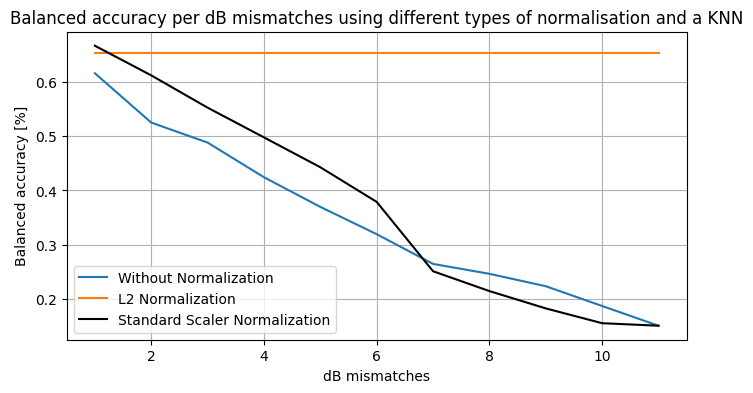

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score as accuracy

# Assuming train_X, train_y are already defined
# Example dummy initialization if needed
# train_X = np.random.randn(100, 10, 10)  
# train_y = np.random.randint(0, 5, 100)  

# Example values for dB mismatches
dB_mismatches = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

# Flatten the data for KNN
train_X_flat = train_X.reshape(train_X.shape[0], -1)

# Precompute L2-normalized and StandardScaler-normalized versions of the full training set
norm_train = np.linalg.norm(train_X_flat, axis=1, keepdims=True)
norm_train[norm_train == 0] = 1  # Avoid division by zero
X_train_l2_full = train_X_flat / norm_train

scaler = StandardScaler()
X_train_standard_full = scaler.fit_transform(train_X_flat)

# Stratified K-Fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize precision arrays
precisions = []
precisions_l2 = []
precisions_standard_scaler = []

for dB_mismatch in dB_mismatches:
    precisions_fold = []
    precisions_l2_fold = []
    precisions_standard_scaler_fold = []

    for idx_learn, idx_val in kf.split(train_X_flat, train_y):
        # Scale validation set with dB mismatch
        X_val_scaled = train_X_flat[idx_val] * 10 ** (-dB_mismatch / 20)

        # --- Without Normalization ---
        model_knn = KNeighborsClassifier(n_neighbors=10)
        model_knn.fit(train_X_flat[idx_learn], train_y[idx_learn])
        prediction_knn = model_knn.predict(X_val_scaled)
        accuracy_knn = accuracy(train_y[idx_val], prediction_knn)
        precisions_fold.append(accuracy_knn)

        # --- L2 Normalization ---
        # Normalize validation set
        norm_val = np.linalg.norm(X_val_scaled, axis=1, keepdims=True)
        norm_val[norm_val == 0] = 1
        X_val_l2 = X_val_scaled / norm_val

        model_knn.fit(X_train_l2_full[idx_learn], train_y[idx_learn])
        prediction_knn_l2 = model_knn.predict(X_val_l2)
        precision_l2 = accuracy(train_y[idx_val], prediction_knn_l2)
        precisions_l2_fold.append(precision_l2)

        # --- StandardScaler Normalization ---
        X_val_standard = scaler.transform(X_val_scaled)

        model_knn.fit(X_train_standard_full[idx_learn], train_y[idx_learn])
        prediction_knn_standard = model_knn.predict(X_val_standard)
        precision_standard = accuracy(train_y[idx_val], prediction_knn_standard)
        precisions_standard_scaler_fold.append(precision_standard)

    # Average the results for the current dB mismatch
    precisions.append(np.mean(precisions_fold))
    precisions_l2.append(np.mean(precisions_l2_fold))
    precisions_standard_scaler.append(np.mean(precisions_standard_scaler_fold))

# --- Plotting the Results ---
plt.figure(figsize=(8, 4))
plt.plot(dB_mismatches, precisions, label='Without Normalization')
plt.plot(dB_mismatches, precisions_l2, label='L2 Normalization')
plt.plot(dB_mismatches, precisions_standard_scaler, label='Standard Scaler Normalization', color='black')
plt.xlabel('dB mismatches')
plt.ylabel('Balanced accuracy [%]')
plt.title('Balanced accuracy per dB mismatches using different types of normalisation and a KNN')
plt.legend()
plt.grid(True)

# Save the plot before showing
plt.savefig('accuracy_per_dB_mismatch.pdf', format='pdf')
plt.show()


In [9]:
from tqdm import tqdm

### TO RUN
# # Initialize the feature matrix and labels for multiple shift_pct values
# X_aug_list = []
# y_aug_list = []

# naudio_sum = sum(naudio.values())
# for shift_pct in tqdm([1,1,1,1,1,1], desc="Processing shift_pct values"):
#     # Create a Feature_vector_DS for the current shift_pct
#     myds_shifted = Feature_vector_DS(dataset, Nft=512, nmel=20, duration=950, shift_pct=shift_pct)
#     myds_shifted.mod_data_aug(["noise", "echo","background_noise"])
    
#     # Initialize feature matrix and labels for the current shift_pct
#     X_aug_shifted = np.zeros((myds_shifted.data_aug_factor * naudio_sum, featveclen))
#     y_aug_shifted = np.empty((myds_shifted.data_aug_factor * naudio_sum), dtype=object)
    
#     # Generate feature vectors and labels
#     for s in range(myds_shifted.data_aug_factor):
#         offset = 0
#         for class_idx, classname in enumerate(classnames):
#             num_samples = naudio[classname]  # Number of samples for the current class
#             for idx in range(num_samples):
#                 featvec = myds_shifted[classname, idx]
#                 X_aug_shifted[s * naudio_sum + offset + idx, :] = featvec
#                 y_aug_shifted[s * naudio_sum + offset + idx] = classname
#             offset += num_samples  # Update the offset for the next class
    
#     # Append the current shift_pct data to the lists
#     print(f"Shape of the feature matrix for shift_pct={shift_pct} : {X_aug_shifted.shape}")
#     X_aug_list.append(X_aug_shifted)
#     y_aug_list.append(y_aug_shifted)

# # Concatenate all feature matrices and labels
# X_aug = np.vstack(X_aug_list)
# y_aug = np.concatenate(y_aug_list)

# # Save the feature matrices
# np.save(fm_dir + "feature_matrix_2D_NN.npy", X_aug)
# np.save(fm_dir + "labels_2D_test_NN.npy", y_aug)

# Load the feature matrices (if necessary)
X_aug = np.load(fm_dir + "feature_matrix_2D_NN.npy")
y_aug = np.load(fm_dir + "labels_2D_test_NN.npy", allow_pickle=True)

print(f"Shape of the feature matrix : {X_aug.shape}")
print(f"Number of labels : {len(y_aug)}")

Shape of the feature matrix : (6576, 400)
Number of labels : 6576


In [ ]:
print(y_aug[0:10])


def plot_specgram(
    specgram,
    ax,
    is_mel=False,
    title=None,
    xlabel="Time [s]",
    ylabel="Frequency [Hz]",
    cmap="jet",
    cb=True,
    tf=None,
    invert=True,
    filename="specgram_plot.pdf"
):
    """
    Plot a spectrogram (2D matrix) in a chosen axis of a figure.
    Inputs:
        - specgram = spectrogram (2D array)
        - ax       = current axis in figure
        - title
        - xlabel
        - ylabel
        - cmap
        - cb       = show colorbar if True
        - tf       = final time in xaxis of specgram
    """
    if tf is None:
        tf = specgram.shape[1]

    if is_mel:
        ylabel = "Frequency [Mel]"
        im = ax.imshow(
            specgram, cmap=cmap, aspect="auto", extent=[0, tf, specgram.shape[0], 0]
        )
    else:
        im = ax.imshow(
            specgram,
            cmap=cmap,
            aspect="auto",
            extent=[0, tf, int(specgram.size / tf), 0],
        )
    if invert:
        ax.invert_yaxis()
    fig = plt.gcf()
    if cb:
        fig.colorbar(im, ax=ax)
    # cbar.set_label('log scale', rotation=270)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.savefig(filename, format='pdf')
    return None
# train_X = train_X.reshape((-1, 20, 20, 1))
X_aug = X_aug.reshape((1, 20, 20, -1))
print(X_aug.shape)
plot_specgram(
    X_aug[0].reshape(20, 20),
    ax=plt.gca(),
    is_mel=True,
    title="melspec of the first sample",
)
plot_specgram(
    X_aug[0].reshape((20, 20,1)) ,
    ax=plt.gca(),
    is_mel=True,
    title="melspec of the first sample",
)

SyntaxError: invalid syntax (3848881715.py, line 56)

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
import keras
import pandas as pd

X_aug -= np.mean(X_aug, axis=0)
X_aug /= np.linalg.norm(X_aug, axis=0)
X_train_normalized, X_test_normalized, y_train, y_test = train_test_split(X_aug, y_aug, 
                                                                          test_size=0.3, 
                                                                          random_state=40,stratify=y_aug)
X_train_normalized = X_train_normalized.reshape(-1, 20, 20, 1)

# Encode string labels into integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
# print(y_train_encoded)
# print(f"Shape of X_train_normalized: {X_train_normalized.shape}")
# print(f"Shape of y_train_encoded: {y_train_encoded.shape}")
# print(f"Number of classes: {len(np.unique(y_train_encoded))}")
def create_cnn_model(dropout_conv=0.25, dropout_dense=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(20, 20, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dropout_conv))

    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dropout_conv))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_dense))
    model.add(Dense(4, activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])  # <--- use function here!
    return model

# model = create_cnn_model()
# # Fit the model on 100 epochs
# model.fit(X_train_normalized, y_train_encoded, epochs=50, batch_size=32, verbose=1)



62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
balanced accuracy score: 0.9616


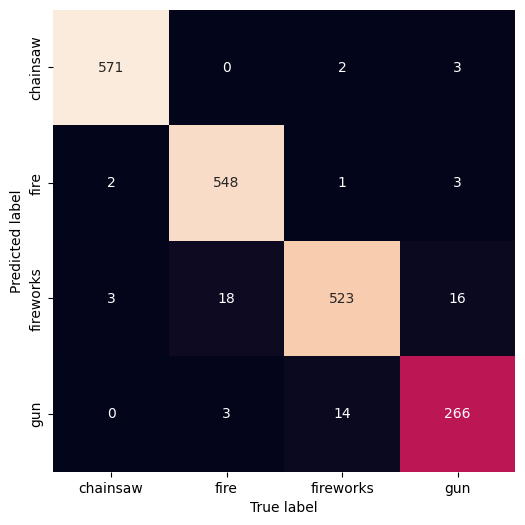

In [24]:
# test_accuracy = 0
# while test_accuracy < 0.96:
#     print("Test accuracy below 0.96, recreating and retraining the model...")
#     model = create_cnn_model()
#     model.fit(X_train_normalized, y_train_encoded, epochs=70, batch_size=32, verbose=1)
#     X_test_reshaped = X_test_normalized.reshape((-1, 20, 20, 1))
#     test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test_encoded, verbose=1)
#     print(f"Test accuracy of the current iteration: {test_accuracy:.4f}")
        
#     X_test_reshaped = X_test_normalized.reshape((-1, 20, 20, 1))

#     y_pred = model.predict(X_test_reshaped)
#     y_pred_classes = np.argmax(y_pred, axis=1)
#     print("balanced accuracy score:", balanced_accuracy_score(y_test_encoded, y_pred_classes).round(4))
#     test_accuracy = balanced_accuracy_score(y_test_encoded, y_pred_classes).round(4)


# model.save("CNN_LAST.keras")
model = keras.models.load_model("CNN_LAST.keras")

y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
print("balanced accuracy score:", balanced_accuracy_score(y_test_encoded, y_pred_classes).round(4))
test_accuracy = balanced_accuracy_score(y_test_encoded, y_pred_classes).round(4)
show_confusion_matrix(y_pred_classes, y_test_encoded, classnames)

In [11]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score, make_scorer
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten, Dense
import pandas as pd

# Define the CNN model for Grid Search
def create_cnn_model(optimizer='adam', learning_rate=0.001, dropout_conv=0.25, dropout_dense=0.5):
    model = Sequential()
    
    # Convolution Block 1
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(20, 20, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_conv))
    
    # Convolution Block 2
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_conv))
    
    # Dense Block
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_dense))
    model.add(Dense(4, activation='softmax'))
    
    # Optimizer choice
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer}")
    
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# # Wrap the Keras model for GridSearchCV
# model = KerasClassifier(
#     model=create_cnn_model,
#     epochs=100,
#     batch_size=32,
#     verbose=0
# )

# # Define the parameter grid for Grid Search
# param_grid = {
#     'model__optimizer': ['adam', 'sgd', 'rmsprop'],
#     'model__learning_rate': [0.001, 0.005, 0.01],
#     'model__dropout_conv': [0.25, 0.5],
#     'model__dropout_dense': [0.5, 0.75],
# }

# # Define a custom scoring function using balanced_accuracy_score
# scorer = make_scorer(balanced_accuracy_score)

# # Perform Grid Search
# grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=3, verbose=1, n_jobs=-1)
# grid_result = grid.fit(X_train_normalized, y_train_encoded)

# # Save results to a CSV file
# results_df = pd.DataFrame(grid_result.cv_results_)
# results_df.to_csv("grid_search_results.csv", index=False)

# # Print the best parameters and score
# print(f"Best Parameters: {grid_result.best_params_}")
# print(f"Best Balanced Accuracy Score: {grid_result.best_score_}")

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
label_encoder_aug = LabelEncoder()
y_aug_encoded = label_encoder_aug.fit_transform(y_aug)

# Ensure the original dataset labels are also encoded
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
# Function to train and evaluate the model
def train_and_evaluate(X, y, num_runs=10):
    scores = []
    for _ in range(num_runs):
        # Split the dataset
        train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=None)
        
        # Reshape the input data to match the expected input shape of the CNN
        train_X = train_X.reshape((-1, 20, 20, 1))
        test_X = test_X.reshape((-1, 20, 20, 1))
        
        # Train the model
        model = create_cnn_model()
        model.fit(train_X, train_y, epochs=50, batch_size=32, verbose=0)
        
        # Make predictions
        y_pred = model.predict(test_X)
        y_pred_classes = np.argmax(y_pred, axis=1)
        
        # Evaluate using balanced accuracy score
        score = balanced_accuracy_score(test_y, y_pred_classes)
        scores.append(score)
    return scores

# Run the process for the original dataset
print("Evaluating on the original dataset...")
original_scores = train_and_evaluate(X, y, num_runs=10)


Evaluating on the original dataset...


/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[11:55:19] WARNING  5 out of the last 65 calls to <function                             ]8;id=569292;file:///home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py\polymorphic_function.py]8;;\:]8;id=498154;file:///home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py#157\157]8;;\
                    TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_d                            
                    istributed at 0x764f945b7940> triggered tf.function retracing.                                 
                    Tracing is expensive and the excessive number of tracings could be                             
                    due to (1) creating @tf.function repeatedly in a loop, (2) passing                             
                    tensors with different shapes, (3) passing Python objects instead                              
                    of tensors. For (1), please define your @tf.function outside of the                            
                    loop. For (2), @tf.function has reduce_retracing=True option that                              
                    can avoid unnecessary retracing. For (3), please refer to                                      
                    https://www.tensorflow.org/guide/function#controlling_retracing and                            
                    https://www.tensorflow.org/api_docs/python/tf/function for  more                               
                    details.                                                                                       

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step

           WARNING  6 out of the last 66 calls to <function                             ]8;id=757420;file:///home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py\polymorphic_function.py]8;;\:]8;id=394012;file:///home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py#157\157]8;;\
                    TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_d                            
                    istributed at 0x764f945b7940> triggered tf.function retracing.                                 
                    Tracing is expensive and the excessive number of tracings could be                             
                    due to (1) creating @tf.function repeatedly in a loop, (2) passing                             
                    tensors with different shapes, (3) passing Python objects instead                              
                    of tensors. For (1), please define your @tf.function outside of the                            
                    loop. For (2), @tf.function has reduce_retracing=True option that                              
                    can avoid unnecessary retracing. For (3), please refer to                                      
                    https://www.tensorflow.org/guide/function#controlling_retracing and                            
                    https://www.tensorflow.org/api_docs/python/tf/function for  more                               
                    details.                                                                                       

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


/tmp/ipykernel_59456/3011958415.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([original_scores, augmented_scores], labels=["Original Dataset", "Augmented Dataset"])


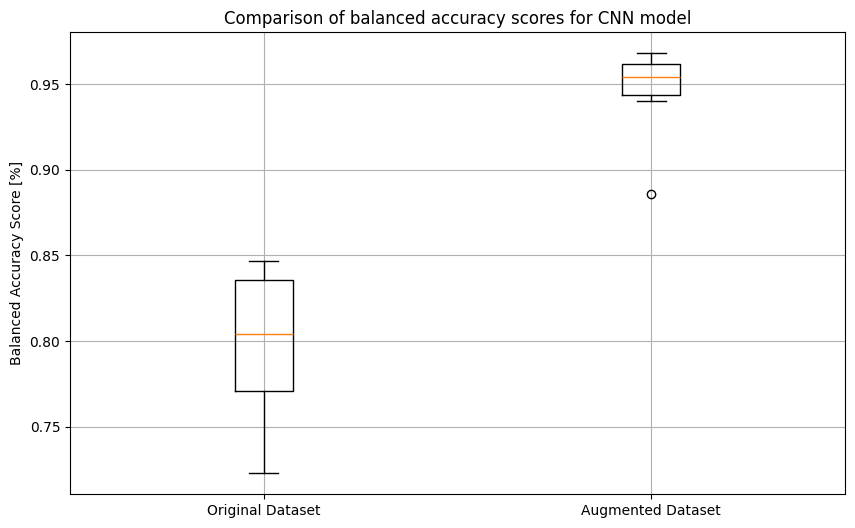

Original Dataset: Mean = 0.7989, Std = 0.0386
Augmented Dataset: Mean = 0.9480, Std = 0.0227


In [13]:
from matplotlib.backends.backend_pdf import PdfPages


# augmented_scores = []
# model = keras.models.load_model("data/models/CNN_LAST.keras")
# for i in range(10):
#     # Split the dataset
#     train_X, test_X, train_y, test_y = train_test_split(X_aug, y_aug_encoded, test_size=0.2, random_state=None)
    
#     # Reshape the input data to match the expected input shape of the CNN
#     train_X = train_X.reshape((-1, 20, 20, 1))
#     test_X = test_X.reshape((-1, 20, 20, 1))
    
#     # Train the model
#     model.fit(train_X, train_y, epochs=50, batch_size=32, verbose=0)
    
#     # Make predictions
#     y_pred = model.predict(test_X)
#     y_pred_classes = np.argmax(y_pred, axis=1)
    
#     # Evaluate using balanced accuracy score
#     score = balanced_accuracy_score(test_y, y_pred_classes)
#     augmented_scores.append(score)
augmented_scores = [94.04,96.8,95.2,95.6,96.4,96.8,95.6,94.2,94.8,88.6]
for i in range(len(augmented_scores)):
    augmented_scores[i] = augmented_scores[i]/100

# Create box plots to compare the results
plt.figure(figsize=(10, 6))
plt.boxplot([original_scores, augmented_scores], labels=["Original Dataset", "Augmented Dataset"])
plt.title("Comparison of balanced accuracy scores for CNN model")
plt.ylabel("Balanced Accuracy Score [%]")
plt.grid(True)
with PdfPages('balanced_accuracy_scores_comparison.pdf') as pdf:
    pdf.savefig()  # saves the current figure
plt.show()

# Save the plot to a PDF file
print(f"Original Dataset: Mean = {np.mean(original_scores):.4f}, Std = {np.std(original_scores):.4f}")
print(f"Augmented Dataset: Mean = {np.mean(augmented_scores):.4f}, Std = {np.std(augmented_scores):.4f}")